In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import math

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
trainData = '/content/gdrive/My Drive/Dataset/TrainData' 

Mounted at /content/gdrive


In [ ]:
data_dir = pathlib.Path(trainData)
image_count = len(list(data_dir.glob('*/*.png')))
print("Number of images:", image_count)

Number of images: 2008


In [ ]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
CLASS_NAMES

array(['pneumonia', 'Tuberculosis', 'Covid', 'Normal'], dtype='<U12')

In [ ]:
image_generator = ImageDataGenerator(rescale=1 / 255, validation_split=0.2)

trainDataset = image_generator.flow_from_directory(directory=str(data_dir), batch_size=32,
                                                     classes=list(CLASS_NAMES),
                                                     target_size=(224, 224),
                                                     shuffle=True, subset="training")

testDataset = image_generator.flow_from_directory(directory=str(data_dir), batch_size=32,
                                                    classes=list(CLASS_NAMES),
                                                    target_size=(224, 224),
                                                    shuffle=True, subset="validation")

Found 1608 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


#CNN

In [ ]:
CN = Sequential()
CN.add(Conv2D(32, kernel_size = (5, 5), activation='relu', input_shape=(224,224,3)))
CN.add(MaxPooling2D(pool_size=(2,2)))
CN.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
CN.add(MaxPooling2D(pool_size=(2,2)))
CN.add(Conv2D(128, kernel_size=(2,2), activation='relu'))
CN.add(MaxPooling2D(pool_size=(2,2)))
CN.add(Flatten())
CN.add(Dense(64, activation='relu'))
CN.add(Dropout(0.5))
CN.add(Dense(32, activation='relu'))
CN.add(Dropout(0.5))
CN.add(Dense(4, activation = 'softmax'))
CN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 53, 53, 128)       32896     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [ ]:
CN.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [ ]:
checkpoint = ModelCheckpoint("CN.h5",
                             save_best_only=True,
                             verbose=1)

In [ ]:
history = CN.fit(trainDataset,
                    validation_data=testDataset, 
                    epochs=10, verbose=1, callbacks=[checkpoint])

Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 1.5010 - acc: 0.2836
Epoch 1: val_loss improved from inf to 1.28483, saving model to CN.h5
51/51 [==============================] - 141s 3s/step - loss: 1.5010 - acc: 0.2836 - val_loss: 1.2848 - val_acc: 0.3850
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 1.2831 - acc: 0.3358
Epoch 2: val_loss improved from 1.28483 to 1.14448, saving model to CN.h5
51/51 [==============================] - 140s 3s/step - loss: 1.2831 - acc: 0.3358 - val_loss: 1.1445 - val_acc: 0.6100
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 1.2313 - acc: 0.4148
Epoch 3: val_loss improved from 1.14448 to 1.04482, saving model to CN.h5
51/51 [==============================] - 137s 3s/step - loss: 1.2313 - acc: 0.4148 - val_loss: 1.0448 - val_acc: 0.6300
Epoch 4/10
51/51 [==============================] - ETA: 0s - loss: 1.1935 - acc: 0.4266
Epoch 4: val_loss did not improve from 1.04482
51/51 [============

In [ ]:
import pickle

In [ ]:
evaluation = CN.evaluate(testDataset)
print("Val loss:", evaluation[0])
print("Val Accuracy:", evaluation[1]*100)

13/13 [==============================] - 9s 685ms/step - loss: 0.7220 - acc: 0.8000
Val loss: 0.7220311760902405
Val Accuracy: 80.0000011920929


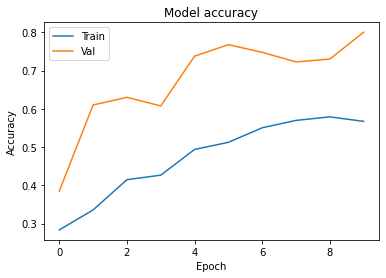

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

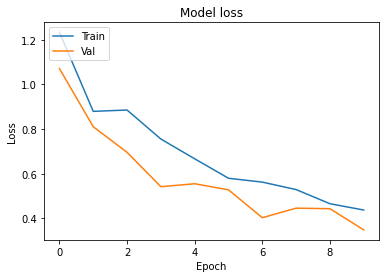

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
new_PRED= CN.predict(testDataset)
classid1=np.argmax(new_PRED,axis=1)

In [ ]:
test_labels = []
for i in range(0,13):
    test_labels.extend(np.array(testDataset[i][1]))

In [ ]:
test_labels

In [ ]:
with open("CN_pickle",'wb')as f:
  pickle.dump(CN,f)

#VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
base_model= VGG16(weights='imagenet',include_top= False,input_shape=(224,224,3))
#leave out last fully connected layer
base_model.summary()

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
cnn= layers.Flatten()(base_model.output)# flatten the output layer to 1 dimension
cnn= layers.Dense(64,activation='relu')(cnn)
cnn= layers.Dropout(0.5)(cnn)
cnn= layers.Dense(32,activation='relu')(cnn)
cnn= layers.Dropout(0.2)(cnn)
cnn= layers.Dense(4,activation='softmax')(cnn)
model = tf.keras.models.Model(base_model.input,cnn)

In [ ]:
model.summary()

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [ ]:
checkpoint = ModelCheckpoint("model.h5",
                             save_best_only=True,
                             verbose=1)

In [ ]:
history = model.fit(trainDataset,
                    validation_data=testDataset, 
                    epochs=10, verbose=1, callbacks=[checkpoint])

In [ ]:
evaluation = model.evaluate(testDataset)
print("Val loss:", evaluation[0])
print("Val Accuracy:", evaluation[1]*100)

In [ ]:
with open("cnn_pickle",'wb')as f:
  pickle.dump(cnn,f)

#ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
base_model1= ResNet50(weights='imagenet',include_top= False,input_shape=(224,224,3))
#leave out last fully connected layer
base_model1.summary()

In [ ]:
for layer in base_model1.layers:
  layer.trainable = False

In [ ]:
cnn1= layers.Flatten()(base_model1.output)
cnn1= layers.Dense(64,activation='relu')(cnn1)
cnn1= layers.Dropout(0.2)(cnn1)
cnn1= layers.Dense(32,activation='relu')(cnn1)
cnn1= layers.Dropout(0.1)(cnn1)
cnn1= layers.Dense(4,activation='softmax')(cnn1)
model1=tf.keras.models.Model(base_model1.input,cnn1)
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
model1.summary()

In [ ]:
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
checkpoint = ModelCheckpoint("model1.h5",
                             save_best_only=True,
                             verbose=1)

In [ ]:
history = model1.fit(trainDataset,
                    validation_data=testDataset, 
                    epochs=10, verbose=1, callbacks=[checkpoint])

In [ ]:
evaluation = model1.evaluate(testDataset)
print("Val loss:", evaluation[0])
print("Val Accuracy:", evaluation[1]*100)

In [ ]:
with open("cnn1_pickle",'wb')as f:
  pickle.dump(cnn1,f)

#InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
base_model2 = InceptionV3(input_shape=(224,224,3),weights='imagenet',include_top= False)
base_model2.summary()

In [ ]:
for layer in base_model2.layers:
  layer.trainable = False

In [ ]:
cnn2= Sequential()
cnn2= layers.Flatten()(base_model2.output)
cnn2= layers.Dense(32,activation='relu')(cnn2)
cnn2= layers.Dropout(0.2)(cnn2)
cnn2= layers.Dense(4,activation='softmax')(cnn2)
model2=tf.keras.models.Model(base_model2.input,cnn2)
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
model2.summary()

In [ ]:
checkpoint = ModelCheckpoint("model2.h5",
                             save_best_only=True,
                             verbose=1)

In [ ]:
history2 = model2.fit(trainDataset,
                    validation_data=testDataset, 
                    epochs=10, verbose=1, callbacks=[checkpoint])

In [ ]:
evaluation = model2.evaluate(testDataset)
print("Val loss:", evaluation[0])
print("Val Accuracy:", evaluation[1]*100)

In [ ]:
with open("cnn2_pickle",'wb')as f:
  pickle.dump(cnn2,f)

#ResNet101

In [ ]:
from tensorflow.keras.applications import DenseNet201

In [ ]:
base_model3= tf.keras.applications.DenseNet201(input_shape=(224,224,3),weights='imagenet',include_top= False)
base_model3.summary()

In [ ]:
for layer in base_model3.layers:
  layer.trainable = False

In [ ]:
cnn3= layers.Flatten()(base_model3.output)
cnn3= layers.Dense(64,activation='relu')(cnn3)
cnn3= layers.Dropout(0.2)(cnn3)
cnn3= layers.Dense(4,activation='softmax')(cnn3)
model3=tf.keras.models.Model(base_model3.input,cnn3)
model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
model3.summary()

In [ ]:
checkpoint = ModelCheckpoint("model3.h5",
                             save_best_only=True,
                             verbose=1)

In [ ]:
history3 = model3.fit(trainDataset,
                    validation_data=testDataset, 
                    epochs=10, verbose=1, callbacks=[checkpoint])

In [ ]:
evaluation = model3.evaluate(testDataset)
print("Val loss:", evaluation[0])
print("Val Accuracy:", evaluation[1]*100)

In [ ]:
with open("cnn3_pickle",'wb')as f:
  pickle.dump(cnn3,f)

#MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet 

In [ ]:
base_model4= tf.keras.applications.MobileNet(input_shape=(224,224,3),weights='imagenet',include_top= False)
base_model4.summary()

In [ ]:
for layer in base_model4.layers:
  layer.trainable = False

In [ ]:
cnn4= layers.Flatten()(base_model4.output)
cnn4= layers.Dense(64,activation='relu')(cnn4)
cnn4= layers.Dropout(0.2)(cnn4)
cnn4= layers.Dense(4,activation='softmax')(cnn4)
model4=tf.keras.models.Model(base_model4.input,cnn4)
model4.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
model4.summary()

NameError: ignored

In [ ]:
checkpoint = ModelCheckpoint("model4.h5",
                             save_best_only=True,
                             verbose=1)

In [ ]:
history4 = model4.fit(trainDataset,
                    validation_data=testDataset, 
                    epochs=10, verbose=1, callbacks=[checkpoint])

In [ ]:
evaluation = model4.evaluate(testDataset)
print("Val loss:", evaluation[0])
print("Val Accuracy:", evaluation[1]*100)

In [ ]:
with open("cnn4_pickle",'wb')as f:
  pickle.dump(cnn4,f)